## Initial Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

os.environ['KAGGLE_USERNAME'] = '*************'
os.environ['KAGGLE_KEY'] = '************************'

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import tensorflow as tf

from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from catboost import CatBoostRegressor

from sklearn import set_config
from sklearn import metrics, preprocessing, model_selection, ensemble
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, accuracy_score, mean_squared_error
from xgboost import XGBRegressor as XGBRegressor
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, BayesianRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.svm import LinearSVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
optuna.logging.set_verbosity(optuna.logging.WARNING)

2024-06-12 11:56:39.434472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:56:39.434640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:56:39.613958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/train.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/test.csv')
train.drop(columns=['patient_id'],inplace=True)
test.drop(columns=['patient_id'],inplace=True)
train.rename(columns={'metastatic_diagnosis_period':'target'}, inplace=True)
test.rename(columns={'metastatic_diagnosis_period':'target'}, inplace=True)

In [4]:
X = train.drop('patient_gender', axis = 1)
y = X.pop('target')

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

seed = 42
splits = 5
kf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
tf.keras.utils.set_random_seed(seed)

In [5]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x[self.cols]

In [7]:
class CustomImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.modes = X.select_dtypes(include=['object', 'category']).mode().iloc[0]
        self.medians = X.select_dtypes(include=[np.number]).median()
        return self
    
    def transform(self, x):
        x_copy = x.copy()
        # Median/Mode Imputation
#         for col in self.modes.index:
#             X_copy[col].fillna(self.modes[col], inplace=True)
        
#         for col in self.medians.index:
#             X_copy[col].fillna(self.medians[col], inplace=True)

        # Impute BMI, Patient Race, Payer Type
        age_bins = [0, 22, 45, 65, 200]
        x_copy['age_bin'] = pd.cut(x['patient_age'].astype(int), bins=age_bins, right=False)
        x_copy['payer_type'] = x_copy.groupby('age_bin')['payer_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
        x_copy['bmi'] = x_copy.groupby('age_bin')['bmi'].transform(lambda x: x.fillna(x.median()))
        x_copy['patient_race'] = x.groupby('patient_zip3')['patient_race'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Other'))
        return x_copy

In [8]:
def desc_cleaner(x):
    x_copy = x.copy()
    
    rep = {
        #'malig ' : 'malignant ',
        'malig ' : '',
        'malignant ' : '',
        #'neoplm' : 'neoplasm',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',
        #' of ' : ' ',
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )
    
    return x_copy

DescCleaner = FunctionTransformer(desc_cleaner)

In [9]:
def desc_indicator(x):
    x_copy = x.copy()
    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'upper' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'lower' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'inner' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'outer' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'axillary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'breast' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'secondary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'other' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'areola' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'overlapping' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'central' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified site' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'male' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'female' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'left' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'right' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified male' in x or 'unspecified female' in x).astype(str)
    return x_copy

DescIndicator = FunctionTransformer(desc_indicator)

In [10]:
def icd_features(x):
    x_copy = x.copy()
    x_copy['type'] = (x_copy.breast_cancer_diagnosis_code.astype(str).str[0] == 'C').astype(np.uint8)
    x_copy['cat'] = x_copy['breast_cancer_diagnosis_code'].astype(str).str[:5]
    x_copy['icd_race'] = x_copy.patient_race.astype(str).str.strip() + '-' + x_copy['type'].astype(str)
    x_copy['icd_state'] = x_copy.patient_state.astype(str).str.strip() + '-' + x_copy['type'].astype(str)
    x_copy['icd_payer'] = x_copy.payer_type.astype(str).str.strip() + '-' + x_copy['type'].astype(str)
    return x_copy

ICDFeatures = FunctionTransformer(icd_features)

In [11]:
def bcdc_cleaner(x):
    df = x.copy()
    data_mapping = {
        '1749': 'C5091',
        '1744': 'C5041',
        '1748': 'C509',
        '1742': 'C5021',
        '1741': 'C5011',
        '1745': 'C5051',
        '1743': 'C5031',
        '1746': 'C5061'
    }
    df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].replace(data_mapping)
    df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].apply(lambda x: x[:4] + '1' + x[5:] if len(x) >= 5 and x[4] == '2' else x)
    df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].replace({'C509': 'C5091'})
    return df

BcdcCleaner = FunctionTransformer(bcdc_cleaner)

In [12]:
def cat_imputer(x):
    x_copy = x.copy()
    x_copy[list(x_copy.select_dtypes('object'))] = x_copy[list(x_copy.select_dtypes('object'))].fillna('Null').astype(str)
    return x_copy

CatImputer = FunctionTransformer(cat_imputer)

In [13]:
def binner(x):
    df = x.copy()
    df['binned_age'] = (df['patient_age'] / 5).astype(np.uint8).astype(str) + '-' + df['type'].astype(str)
    df['bmi_recorded'] = np.where(df['bmi'].isna(), 0, 
                                np.where(df['bmi'] < 18.5, 1, 
                                np.where(df['bmi'] < 25, 2, 
                                np.where(df['bmi'] < 30, 3, 4))))
    df['icd_bmi'] = df.bmi_recorded.astype(str) + '-' + df['type'].astype(str)
    return df#.astype({'binned_age' : 'object'})

Binner = FunctionTransformer(binner)

In [14]:
def temp_features(x):
    x_copy = x.copy()
    pattern = re.compile(r'Average of \w{3}-\d{2}')
    relevant_columns = list(filter(pattern.match, x.columns))

    df_long = x[relevant_columns].melt(var_name='Month-Year', value_name='Temperature')
    df_long['Month'] = df_long['Month-Year'].apply(lambda x: x.split()[2].split('-')[0])
    df_long['Year'] = df_long['Month-Year'].apply(lambda x: '20' + x.split()[2].split('-')[1])
    monthly_mean = df_long.groupby('Month')['Temperature'].mean().reset_index()
    cols = []

    for month in monthly_mean['Month']:
        mean_temp = df_long[df_long['Month'] == month]['Temperature'].mean()
        x_copy[f'{month}'] = mean_temp
        cols.append(month)
    
    x_copy['max_temp'] = x_copy[cols].max(axis=1)
    return x_copy

TempFeatures = FunctionTransformer(temp_features)

In [15]:
pre = make_pipeline(TempFeatures, DescCleaner, DescIndicator, ICDFeatures, Binner)
temp = pre.transform(train)

In [16]:
temp.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,target,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,max_temp,type,cat,icd_race,icd_state,icd_payer,binned_age,bmi_recorded,icd_bmi
0,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,FalseFalseFalseFalseFalseTrueFalseFalseFalseFa...,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191,55.929144,75.0454,41.901614,40.593504,37.529862,76.101177,72.747166,47.064394,64.913018,48.810434,60.632756,70.706177,76.101177,1,C5091,nan-1,AR-1,COMMERCIAL-1,7-1,0,0-1
1,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,TrueFalseFalseTrueFalseTrueFalseFalseFalseFals...,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,

In [17]:
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# X = cortemp[['patient_zip3', 'patient_state']]
# X = sm.add_constant(X)

# vif_data = pd.DataFrame()
# vif_data['Feature'] = X.columns
# vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Remove the constant column from VIF results
# vif_data = vif_data[vif_data["Feature"] != "const"]

# print("\nVariance Inflation Factor (VIF):")
# print(vif_data)

<Axes: xlabel='icd_race', ylabel='target'>

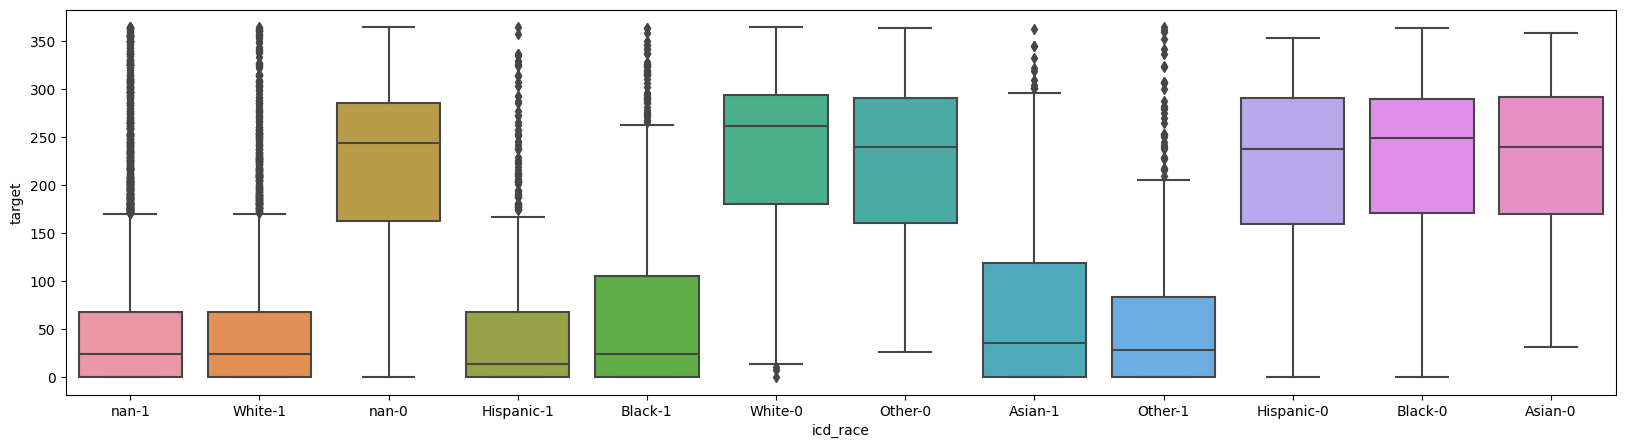

In [18]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.boxplot(data=temp, x='icd_race', y='target')

<Axes: xlabel='bmi', ylabel='target'>

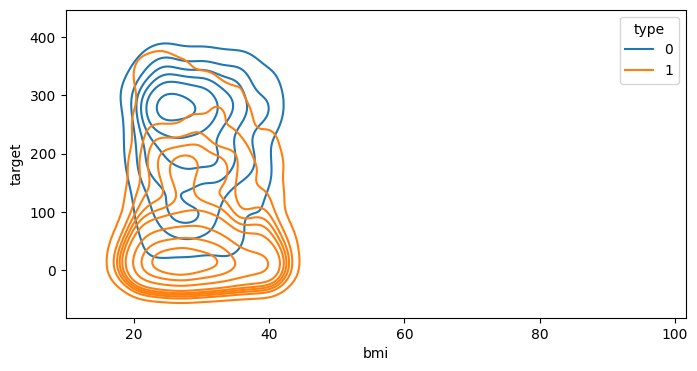

In [19]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=temp, x='bmi', y='target', hue='type')

In [20]:
def cross_val_score(estimator, cv = kf, label = '', show_importance = False, pseudolabelling = False):
    
    X = train.copy()
    y = X.pop('target')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores= [], []
    
    feature_importances_table = pd.DataFrame({'value' : 0}, index = list(X.columns))
    
    test_predictions = np.zeros((len(test)))
    icd = (X.breast_cancer_diagnosis_code.astype(str).str[0] == 'C').astype(np.uint8)
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, icd)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        #define validation set
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        #train model
        model.fit(X_train, y_train)
        
        if pseudolabelling:
            pseudolabel = model.predict(X_val)
            
            pseudo_X = pd.concat([X_train, X_val]).reset_index(drop = True)
            pseudo_y = pd.concat([y_train, pd.Series(pseudolabel)]).reset_index(drop = True)
            
            model.fit(pseudo_X, pseudo_y)
        
        #make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds.reshape(-1)
        test_predictions += model.predict(test).reshape(-1) / cv.get_n_splits()
        if show_importance:
            feature_importances_table['value'] += permutation_importance(model, X_val, y_val, random_state = seed, scoring = make_scorer(rmse), n_repeats = 5).importances_mean / cv.get_n_splits()
        
        #evaluate model for a fold
        train_score = rmse(y_train, train_preds)
        val_score = rmse(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
       
    if show_importance:
        plt.figure(figsize = (20, 30))
        plt.title(f'Features with Biggest Importance of {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} Model', size = 25, weight = 'bold')
        sns.barplot(feature_importances_table.sort_values('value', ascending = False).T, orient = 'h', palette = 'viridis')
        plt.show()
    else:
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions, test_predictions

In [21]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### Ridge Regressor

In [22]:
Ridger = make_pipeline(
    pre,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code','metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'icd_state', 'icd_payer', 'icd_race', 'icd_bmi']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division', 'cat', 'binned_age']),
    CatBoostEncoder(cols = ['patient_zip3']),
    SimpleImputer(),
    FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'Division', 'patient_zip3', 'home_ownership', 'family_size', 'self_employed', 'income_individual_median', 'labor_force_participation', 'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
    Ridge()
)

_, oof_list['Ridge'], predict_list['Ridge'] = cross_val_score(Ridger)

Val Score: 82.86010 ± 1.38893 | Train Score: 81.68446 ± 0.34570 | 


### K-Nearest Neighbors Regressor

In [23]:
KNN = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['patient_gender','cat', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division', 'binned_age']),
    FeatureSelector(['type', 'patient_zip3', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc']),
    SimpleImputer(),
    StandardScaler(),
    KNeighborsRegressor(50)
)

_, oof_list['KNN'], predict_list['KNN'] = cross_val_score(KNN)

Val Score: 82.90680 ± 1.35815 | Train Score: 80.88505 ± 0.32714 | 


### Random Forest Regressor

In [24]:
RF = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['cat', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'binned_age', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
    SimpleImputer(),
    RandomForestRegressor(random_state = seed, criterion = 'squared_error', max_depth=5)
)

_, oof_list['RF'], predict_list['RF'] = cross_val_score(RF)

Val Score: 82.39347 ± 1.35207 | Train Score: 80.42945 ± 0.32532 | 


### Extra Trees Regressor

In [25]:
ET = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
    SimpleImputer(),
    ExtraTreesRegressor(random_state = seed, max_depth=5)
)

_, oof_list['ET'], predict_list['ET'] = cross_val_score(ET)

Val Score: 82.55824 ± 1.41410 | Train Score: 81.30609 ± 0.31893 | 


### Gradient Boosting Regressor

In [26]:
def gb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', .001, .1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'subsample': trial.suggest_float('subsample', .1, 1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 50),
        # No need for n_estimators as you've already set it to a fixed value
        'random_state': seed,
    }
    
    optuna_model = make_pipeline(
        CustomImputer(),
        pre,
        MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
        MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
        FeatureSelector(['binned_age', 'breast_cancer_diagnosis_code', 'patient_age', 'race_other',
         'metastatic_cancer_diagnosis_code', 'icd_payer', 'icd_state', 'patient_race']),
        SimpleImputer(),
        GradientBoostingRegressor(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

gb_study = optuna.create_study(direction = 'minimize')

In [27]:
# gb_study.optimize(gb_objective, 200)
# best_trial = gb_study.best_trial
# gb_params = best_trial.params
# print(gb_params)

In [28]:
# gb_params = {'learning_rate': 0.07857513446098478, 'max_depth': 3, 'subsample': 0.8612129212105573, 'min_samples_split': 39, 'min_samples_leaf': 18}   # 81.30669
gb_params = {'learning_rate': 0.025090170338381984, 'max_depth': 5, 'subsample': 0.8806789021834932, 'min_samples_split': 49, 'min_samples_leaf': 24}

GB = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer','patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['binned_age', 'breast_cancer_diagnosis_code', 'patient_age', 'race_other',
         'metastatic_cancer_diagnosis_code', 'icd_payer', 'icd_state', 'patient_race']),
    SimpleImputer(),
    GradientBoostingRegressor(random_state = seed)
)

_, oof_list['GB'], predict_list['GB'] = cross_val_score(GB)

Val Score: 82.20076 ± 1.13896 | Train Score: 79.54039 ± 0.25306 | 


### Hist Gradient Boosting

In [29]:
def hgb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', .001, .1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        # Use max_leaf_nodes instead of max_leaf_nodes (one typo)
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', .1, 20, log=True),
        # Use max_iter instead of max_iter (one typo)
        'max_iter': trial.suggest_int('max_iter', 100, 1000),  # Adjust range for HistGradientBoostingRegressor
        'random_state': seed,
    }

    
    optuna_model = make_pipeline(
        pre,
        MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
        MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
        FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'Division',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
        SimpleImputer(),
        HistGradientBoostingRegressor(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

hgb_study = optuna.create_study(direction = 'minimize')

In [30]:
# hgb_study.optimize(hgb_objective, 200)
# best_trial = hgb_study.best_trial
# hgb_params = best_trial.params

In [31]:
hgb_params = {'learning_rate': 0.025227604412897862, 'max_depth': 7, 'max_leaf_nodes': 10, 'min_samples_leaf': 22, 'l2_regularization': 0.5276606374400471, 'max_iter': 893} # 82.0715
# hgb_params = {'learning_rate': 0.03840967923611026, 'max_depth': 15, 'max_leaf_nodes': 17, 'min_samples_leaf': 27, 'l2_regularization': 0.10001251956553192, 'max_iter': 886}

HGB = make_pipeline(
    #MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    #MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
    SimpleImputer(),
    HistGradientBoostingRegressor(**hgb_params, random_state = seed)
)

_, oof_list['HGB'], predict_list['HGB'] = cross_val_score(HGB)

Val Score: 82.07156 ± 1.26931 | Train Score: 79.94839 ± 0.42408 | 


### XGBoost

In [32]:
def xgb_objective(trial):
    params = {
        'eta' : trial.suggest_float('eta', .001, .3, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 20, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .01, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .01, 10, log = True),
        'n_estimators' : 750,
        'random_state' : seed,
        'tree_method' : 'hist',
    }
    
    optuna_model = make_pipeline(
        pre,
        MEstimateEncoder(cols = ['type', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
        MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
        FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
        XGBRegressor(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

xgb_study = optuna.create_study(direction = 'minimize')

In [33]:
# xgb_study.optimize(xgb_objective, 200)
# best_trial = xgb_study.best_trial
# xgb_params = best_trial.params
# print(xgb_params)

In [34]:
# xgb_params = {'eta': 0.008543238981863092, 'max_depth': 8, 'subsample': 0.7552163746659539, 'colsample_bytree': 0.2691660952772145, 'min_child_weight': 2.7951150047377378, 'reg_lambda': 13.521555600810693, 'reg_alpha': 0.183558918808466} #81.99
xgb_params = {'eta': 0.006284707407493742, 'max_depth': 8, 'subsample': 0.9997486987847032, 'colsample_bytree': 0.30007422580910137, 'min_child_weight': 1.1681683067613406, 'reg_lambda': 17.426277615776215, 'reg_alpha': 0.03799049645363269}

XGB = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['type', 'binned_age', 'Division', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    FeatureSelector(cols = ['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
    XGBRegressor(**xgb_params, random_state = seed, n_estimators = 750, tree_method = 'hist')
)

_, oof_list['XGB'], predict_list['XGB'] = cross_val_score(XGB, show_importance = False)

Val Score: 81.97166 ± 1.33767 | Train Score: 77.32642 ± 0.34335 | 


### LGBM Regressor

In [35]:
def lgb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 600,
        'random_state' : seed,
        'boosting_type' : 'dart',
        'verbosity': -1,
        'device': 'gpu'
    }
    
    optuna_model = make_pipeline(
        pre,
        MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer','patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
        MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
        FeatureSelector(['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'Division',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']),
        LGBMRegressor(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

lgb_study = optuna.create_study(direction = 'minimize')

In [36]:
# lgb_study.optimize(lgb_objective, 200)

In [37]:
# lgb_params = {'learning_rate': 0.08359446088473024, 'max_depth': 3, 'subsample': 0.8074313150933488, 'min_child_weight': 0.11814074951268909, 'reg_lambda': 7.854058970221475, 'reg_alpha': 0.2100734512461467} #82.73
lgb_params = {'learning_rate': 0.07921975278851727, 'max_depth': 3, 'subsample': 0.9021811925535176, 'min_child_weight': 4.3363132208862964, 'reg_lambda': 0.18934163749780367, 'reg_alpha': 2.4403844347714725}

LGB = make_pipeline(
    CustomImputer(),
    pre,
    MEstimateEncoder(cols = ['cat', 'binned_age', 'icd_bmi', 'icd_race', 'icd_state', 'icd_payer','patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['breast_cancer_diagnosis_code', 'family_size', 'patient_age', 'disabled',
         'metastatic_cancer_diagnosis_code','icd_state']),
    LGBMRegressor(**lgb_params, random_state = seed, verbose=-1)
)

_, oof_list['LGB'], predict_list['LGB'] = cross_val_score(LGB, show_importance = False)

Val Score: 82.21215 ± 1.25163 | Train Score: 80.15833 ± 0.22751 | 


### LGBM Dart

In [38]:
dart_params = {'learning_rate': 0.09914137430412352, 'max_depth': 2, 'subsample': 0.9969294146161065, 'min_child_weight': 11.914829509929072, 'reg_lambda': 6.522351674703635, 'reg_alpha': 0.295532729556387}

DART = make_pipeline(
    pre,
    MEstimateEncoder(cols = ['patient_state', 'payer_type', 'Region', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    FeatureSelector(cols = ['patient_age', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Aug', 'Jul', 'Jun', 'disabled']),
    LGBMRegressor(**dart_params, random_state = seed, n_estimators = 600, boosting_type = 'dart', verbose=-1)
)

_, oof_list['DART'], predict_list['DART'] = cross_val_score(DART, show_importance = False)

Val Score: 82.70833 ± 1.30922 | Train Score: 81.86917 ± 0.30024 | 


### CatBoost

In [39]:
def cb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),  # Narrowed range
        'depth': trial.suggest_int('depth', 3, 10),  # Narrowed range
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),  # Narrowed range
        'random_seed': seed,
        'verbose': False,
        # 'task_type': 'GPU'  # Uncomment if you want to use GPU, which can speed up training
    }
    
    cb_features = ['breast_cancer_diagnosis_code', 'patient_age', 'disabled',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']
    cb_cat = ['breast_cancer_diagnosis_code',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']
    
    optuna_model = make_pipeline(
        pre,
        CatImputer,
        FeatureSelector(cb_features),
        CatBoostRegressor(**params, cat_features = cb_cat, bootstrap_type = 'Bernoulli', has_time=True)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

cb_study = optuna.create_study(direction = 'minimize')

In [40]:
# cb_study.optimize(cb_objective, 20)
# best_trial = cb_study.best_trial
# cb_params = best_trial.params
# print(cb_params)

In [41]:
cb_features = ['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi', 'disabled',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state', 'patient_age']
cb_cat = ['type', 'binned_age', 'breast_cancer_diagnosis_code', 'icd_bmi',
         'metastatic_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'icd_race', 'icd_payer', 'icd_state']

# cb_params = {'learning_rate': 0.010663586799405909, 'depth': 13, 'l2_leaf_reg': 0.20115722271299316} #81.97
cb_params = {'learning_rate': 0.046712098817202376, 'depth': 6, 'l2_leaf_reg': 9.45594815653324}

CB = make_pipeline(
    pre,
    CatImputer,
    FeatureSelector(cols = cb_features),
    CatBoostRegressor(random_state = seed, verbose = 0, cat_features = cb_cat)
)

_, oof_list['CB'], predict_list['CB'] = cross_val_score(CB)

Val Score: 81.84448 ± 1.04149 | Train Score: 77.67525 ± 0.34232 | 


In [42]:
cb_time_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'income_household_35_to_50']
cb_time_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_time_params = {'learning_rate': 0.048326724219233175, 'depth': 3, 'subsample': 0.8589378552114382, 'l2_leaf_reg': 1.7000522641901692}

CB_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_time_features),
    CatBoostRegressor(random_state = seed, verbose = 0, cat_features = cb_time_cat, has_time = True)
)

_, oof_list['CB_Time'], predict_list['CB_Time'] = cross_val_score(CB_Time)

Val Score: 82.61108 ± 0.85626 | Train Score: 77.92157 ± 0.35021 | 


### CB Bayesian

In [43]:
cb_bayes_features = ['breast_cancer_diagnosis_code', 'icd_bmi', 'patient_age', 'disabled',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']
cb_bayes_cat = ['breast_cancer_diagnosis_code', 'icd_bmi',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']

cb_bayes_params = {'learning_rate': 0.03874261097700202, 'depth': 4, 'l2_leaf_reg': 7.189026716451241}

CB_Bayes = make_pipeline(
    pre,
    CatImputer,
    FeatureSelector(cols = cb_bayes_features),
    CatBoostRegressor(random_state = seed, verbose = 0, bootstrap_type = 'Bayesian', cat_features = cb_bayes_cat)
)

_, oof_list['CB_Bayes'], predict_list['CB_Bayes'] = cross_val_score(CB_Bayes)

Val Score: 82.04505 ± 0.98981 | Train Score: 77.04353 ± 0.34248 | 


In [44]:
cb_bayes_time_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'income_household_50_to_75', 'health_uninsured']
cb_bayes_time_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

CB_Bayes_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_bayes_time_features),
    CatBoostRegressor(random_state = seed, verbose = 0, bootstrap_type = 'Bayesian', cat_features = cb_bayes_time_cat, has_time = True)
)

_, oof_list['CB_Bayes_Time'], predict_list['CB_Bayes_Time'] = cross_val_score(CB_Bayes_Time)

Val Score: 82.84335 ± 0.90297 | Train Score: 75.64861 ± 0.29003 | 


### CB Bernoulli

In [45]:
cb_bernoulli_features = ['breast_cancer_diagnosis_code', 'icd_bmi', 'patient_age', 'disabled',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']
cb_bernoulli_cat = ['breast_cancer_diagnosis_code', 'icd_bmi',
         'metastatic_cancer_diagnosis_code','icd_payer', 'icd_state']

cb_bernoulli_params = {'learning_rate': 0.03874261097700202, 'depth': 4, 'l2_leaf_reg': 7.189026716451241}

CB_Bernoulli = make_pipeline(
    pre,
    CatImputer,
    FeatureSelector(cols = cb_bernoulli_features),
    CatBoostRegressor(random_state = seed, verbose = 0, bootstrap_type = 'Bernoulli', cat_features = cb_bernoulli_cat)
)

_, oof_list['CB_Bernoulli'], predict_list['CB_Bernoulli'] = cross_val_score(CB_Bernoulli)

Val Score: 82.03377 ± 0.97541 | Train Score: 76.66338 ± 0.35664 | 


In [46]:
cb_bernoulli_time_features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Jun', 'Jul', 'unemployment_rate', 'self_employed']
cb_bernoulli_time_cat = ['patient_race', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_bernoulli_time_params = {'learning_rate': 0.048326724219233175, 'depth': 3, 'subsample': 0.8589378552114382, 'l2_leaf_reg': 1.7000522641901692}

CB_Bernoulli_Time = make_pipeline(
    pre,
    CatImputer,
    FeatureSelector(cols = cb_bernoulli_time_features),
    CatBoostRegressor(**cb_bernoulli_time_params, random_state = seed, verbose = 0, bootstrap_type = 'Bernoulli', cat_features = cb_bernoulli_time_cat, has_time = True)
)

_, oof_list['CB_Bernoulli_Time'], predict_list['CB_Bernoulli_Time'] = cross_val_score(CB_Bernoulli_Time)

Val Score: 81.99694 ± 1.14993 | Train Score: 79.53623 ± 0.25388 | 


## Ensemble

In [47]:
def multiplier_objective(trial):
    
    multipliers = np.array([trial.suggest_float(f'{label}', -1, 1) for label in list(oof_list)])
    
    return rmse(train.target, oof_list.to_numpy() @ (multipliers / multipliers.sum()))

multiplier_study = optuna.create_study(direction = 'minimize')

In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [49]:
multiplier_study.optimize(multiplier_objective, 3000)
best_trial = multiplier_study.best_trial
print(best_trial.values)
best_params = best_trial.params

[81.50187376325741]


In [50]:
#selected_model = [col] + ['CB_Bernoulli_Time', 'CB_Bernoulli', 'Log', 'TF', 'ET', 'SVM', 'CB', 'RF', 'LGB', 'KNN', 'CB_Time', 'CB_Bayes_Time', 'CB_Bayes', 'GNB', 'BNB', 'LDA', 'XGB', 'GB']
#weights = RidgeClassifier(random_state = seed).fit(oof_list, train.DiagPeriodL90D).coef_[0]
#weights = np.array(list(multiplier_study.best_params.values()))
weights = np.array(list(best_params.values()))
weights /= weights.sum()
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
Ridge,-0.184992
KNN,0.082886
RF,0.248375
ET,-0.061361
GB,0.089385
HGB,0.236597
XGB,0.124848
LGB,-0.018239
DART,-0.277522
CB,0.221893


In [51]:
print(f'Score: {rmse(train.target, oof_list.to_numpy() @ weights)}')
predictions = predict_list.to_numpy() @ weights

Score: 81.50187376325741


In [52]:
submission = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')
submission['metastatic_diagnosis_period'] = np.clip(predictions, a_min=0, a_max=np.inf)
submission.to_csv('submission.csv', index=False)
submission.head()

,patient_id,metastatic_diagnosis_period
0,730681,198.967950
1,334212,64.074388
2,571362,193.976048
3,907331,208.673148
4,208382,41.952541
